In [ ]:
println("test")

# Download Dataset

In [ ]:
mkdir("../dataset")
cd("../dataset") do
    run(`wget http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip`) 
    run(`unzip mini_speech_commands.zip`)
end
using Markdown

Markdown.parse_file("../dataset/mini_speech_commands/README.md")

In [ ]:
readdir("../dataset/mini_speech_commands")

In [ ]:
readdir("../dataset/mini_speech_commands/down")

In [ ]:
using WAV
s, fs = wavread("../dataset/mini_speech_commands/down/feb1d305_nohash_1.wav")
wavplay(s,fs)

In [1]:
commands = [c for c=readdir("../dataset/mini_speech_commands") if c!="README.md"]

8-element Vector{String}:
 "down"
 "go"
 "left"
 "no"
 "right"
 "stop"
 "up"
 "yes"

In [2]:

using Glob
using Random
filenames = glob("../dataset/mini_speech_commands/*/*") |> shuffle
num_examples = length(readdir("../dataset/mini_speech_commands/$(commands[1])"))
println("Number of total examples: ",length(filenames))
println("Number of examples per label: ", num_examples)
println("Example File Tensor: ", filenames[1])

Number of total examples: 8000
Number of examples per label: 1000
Example File Tensor: ..\dataset\mini_speech_commands\stop\6af4aa07_nohash_1.wav


In [3]:
train_files = filenames[1:6400]
val_files = filenames[6401:7200]
test_files = filenames[7201:8000]

println("Training set size: ", length(train_files))
println("Validation set size: ", length(val_files))
println("Test set size: ", length(test_files))

Training set size: 6400
Validation set size: 800
Test set size: 800


In [4]:
using WAV
test_audio, fs = wavread("../dataset/mini_speech_commands/down/0a9f9af7_nohash_0.wav")
@show fs
@show size(test_audio)

fs = 16000.0f0
size(test_audio) = (13654, 1)


(13654, 1)

In [5]:
function decode_audio(audio_binary)
    audio, fs = wavread(audio_binary)
    audio[:,1]
end
decode_audio("../dataset/mini_speech_commands/down/0a9f9af7_nohash_0.wav")

13654-element Vector{Float64}:
 0.0017700735496078372
 0.002990813928647725
 0.002838221381267739
 0.003021332438123722
 0.0024719992675557726
 0.003143406476027711
 0.0027466658528397473
 0.0019531846064638203
 0.0020142216254158147
 0.0019226660969878231
 0.0018005920590838343
 0.001098666341135899
 0.0018311105685598315
 ⋮
 0.016907254249702446
 0.01913510544145024
 0.020264290292062136
 0.020477919858394117
 0.020020142216254158
 0.020264290292062136
 0.021698660237434005
 0.023102511673329874
 0.025818659016693626
 0.025269325846125675
 0.029725028229621267
 0.017761772515030368

In [6]:
function get_label(file_path)
    split(file_path,"\\")[end-1] # For Windows System otherwise replace with /
end
get_label(filenames[1])

"stop"

In [7]:
get_waveform_and_label(file_path) = decode_audio(file_path), get_label(file_path)

get_waveform_and_label(filenames[1])


([0.002533036286507767, 0.0029602954191717277, 0.004119998779259621, 0.006653035065767388, 0.008667256691183203, 0.008453627124851223, 0.007751701406903287, 0.007110812707907346, 0.007049775688955351, 0.0068971831415753655  …  0.004943998535111545, 0.006225775933103427, 0.007354960783715323, 0.008178960539567248, 0.007751701406903287, 0.006469924008911405, 0.006622516556291391, 0.006439405499435408, 0.005676442762535478, 0.00424207281716361], "stop")

In [8]:
train_ds = get_waveform_and_label.(train_files)

6400-element Vector{Tuple{Vector{Float64}, SubString{String}}}:
 ([0.002533036286507767, 0.0029602954191717277, 0.004119998779259621, 0.006653035065767388, 0.008667256691183203, 0.008453627124851223, 0.007751701406903287, 0.007110812707907346, 0.007049775688955351, 0.0068971831415753655  …  0.004943998535111545, 0.006225775933103427, 0.007354960783715323, 0.008178960539567248, 0.007751701406903287, 0.006469924008911405, 0.006622516556291391, 0.006439405499435408, 0.005676442762535478, 0.00424207281716361], "stop")
 ([0.005676442762535478, 0.006225775933103427, 0.006683553575243385, 0.00695822016052736, 0.007080294198431349, 0.00695822016052736, 0.006347849971007416, 0.0054322946867275, 0.004852443006683554, 0.0042115543076876125  …  0.023407696768089847, 0.02328562273018586, 0.023407696768089847, 0.023133030182805873, 0.02328562273018586, 0.023133030182805873, 0.02264473403118992, 0.022980437635425885, 0.021057771538438064, 0.023560289315469832], "up")
 ([0.004547257911923582, 0.007171

In [9]:
using Plots

rows = 3
cols = 3

n = rows*cols

figs = [
    plot(
        (1:length(train_ds[i][1]))./1e3, train_ds[i][1],
        title = train_ds[i][2],
        yticks = -1.2:0.4:1.2,
        label = train_ds[i][2],
        ylim = (-1.3,1.3),
        xticks = 0:5:15,
    )
    for i=1:n
]

plot(figs...,layout=(rows,cols))

In [10]:
using DSP
# TODO need an extra dimension for batches
function get_spectrogram(waveform)
    input_len = 16000
    waveform = length(waveform) >= input_len ? 
                    waveform[1:input_len]    :
                    [convert.(Float32,waveform);zeros(Float32,input_len - length(waveform))]
    spectrogram = DSP.stft(
        waveform,
        255,
        128, 
    ) |> x->abs.(x)
    spectrogram
end

get_spectrogram(train_ds[1][1])

129×124 Matrix{Float64}:
 0.460494    0.350444    0.0276498    0.110569    …  0.143529     0.818018
 0.0546656   0.166196    0.127271     0.236565       0.231777     0.263754
 0.233799    0.221992    0.101361     0.0415771      0.0404693    0.0937782
 0.0627781   0.0237963   0.131612     0.0423761      0.0940451    0.123413
 0.0289908   0.033122    0.0789443    0.0533211      0.109043     0.0554946
 0.199457    0.202781    0.0302613    0.0446174   …  0.0894915    0.0531329
 0.0791341   0.171505    0.133794     0.0962217      0.195719     0.115581
 0.0343084   0.121562    0.131236     0.101031       0.19558      0.180733
 0.281756    0.192606    0.146977     0.185057       0.152753     0.189818
 0.119716    0.0712992   0.0989342    0.09737        0.192721     0.1581
 0.274983    0.0707778   0.0522357    0.157098    …  0.19744      0.12849
 0.0387653   0.182784    0.092466     0.187953       0.11901      0.101351
 0.0684917   0.0942517   0.117226     0.0454909      0.0932213    0.0861235

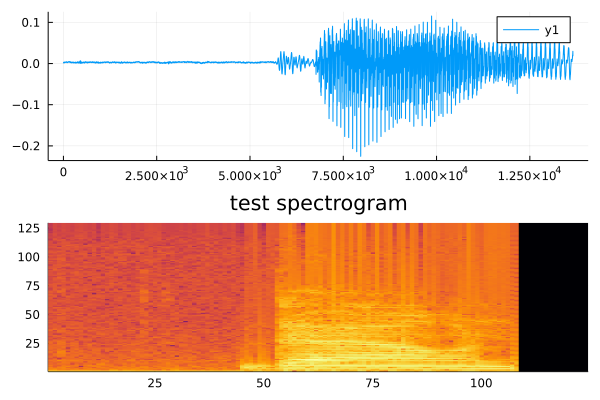

In [11]:
function plot_spectrogram(spectrogram, title)
    tmp = similar(spectrogram)
    if (length(size(spectrogram))>2)
        @assert length(size(spectrogram)) == 4
        tmp = spectrogram[:,:,1]
    else
        tmp = spectrogram
    end
    log_spec = log.(tmp .+ eps(Float32))
    heatmap(log_spec, legend=false, title=title)
end


tst_waveform = decode_audio("../dataset/mini_speech_commands/down/0a9f9af7_nohash_0.wav")
tst_spectrogram = get_spectrogram(tst_waveform)

p1 = plot(tst_waveform)
p2 = plot_spectrogram(tst_spectrogram, "test spectrogram")

plot(p1,p2, layout=(2,1))

In [29]:
using Flux
function get_spectrogram_and_label_id((waveform, label))
    spectrogram = convert.(Float32,get_spectrogram(waveform))
    reshape(spectrogram,size(spectrogram)...,1), Flux.onehot(label,commands)
end

x,y = get_spectrogram_and_label_id((train_ds[1][1], train_ds[1][2]))
p1 = plot(train_ds[1][1][:,:,1,1],title="$(train_ds[1][2])")
@show size(x)
p2 = plot_spectrogram(x, "$(train_ds[1][2])")
@show commands
plot(p1, p2, layout=(2,1)) |> display
println(y)

LoadError: DimensionMismatch("mismatch in dimension 2 (expected 124 got 1)")

In [13]:
spectrogram_ds = get_spectrogram_and_label_id.(train_ds)

6400-element Vector{Tuple{Array{Float32, 4}, Flux.OneHotArray{UInt32, 8, 0, 1, UInt32}}}:
 ([0.4604938 0.35044405 … 0.14352855 0.81801814; 0.054665558 0.16619577 … 0.23177658 0.2637544; … ; 0.0024247447 0.0017815968 … 0.0013224963 0.0012464746; 0.0025330363 0.001556444 … 0.001495407 0.0010376293;;;;], [0, 0, 0, 0, 0, 1, 0, 0])
 ([1.4956511 0.5917844 … 0.48841822 4.380108; 0.28852186 0.4700405 … 1.2423198 1.3202645; … ; 0.0030938552 0.004988419 … 0.0010986269 0.017272465; 0.003051851 0.004974517 … 0.0012207404 0.017242959;;;;], [0, 0, 0, 0, 0, 0, 1, 0])
 ([0.85317546 0.7097079 … 0.0 0.0; 0.2867956 0.26292527 … 0.0 0.0; … ; 0.0026194488 0.0016899524 … 0.0 0.0; 0.0026245713 0.0018616319 … 0.0 0.0;;;;], [0, 0, 0, 0, 1, 0, 0, 0])
 ([0.00076296274 6.103702f-5 … 3.051851f-5 0.0013733329; 0.00032269245 0.0008908718 … 0.0010868796 0.0014171988; … ; 0.00015016399 0.000110437366 … 0.0010369382 0.00035027778; 0.00027466659 0.0 … 0.00045777764 0.0005798517;;;;], [0, 0, 1, 0, 0, 0, 0, 0])
 ([0.36024

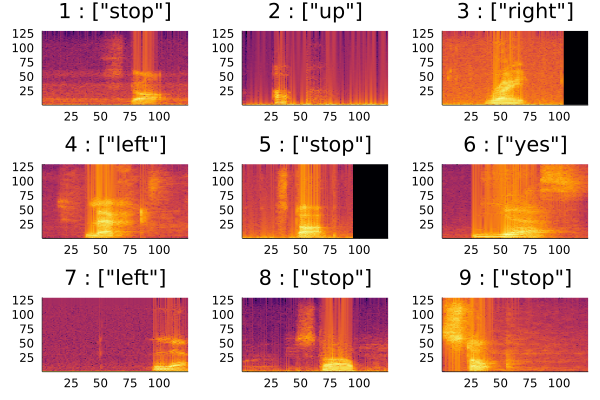

In [14]:
rows = 3
cols = 3
n = rows*cols

figs = [
    plot_spectrogram(spectrogram_ds[i][1][:,:,1,1],"$i : $(commands[spectrogram_ds[i][2]])")
    for i=1:n
]

plot(figs...,layout=(rows,cols))

In [15]:
wavplay(train_ds[1][1],fs)
wavplay(train_ds[2][1],fs)
wavplay(train_ds[5][1],fs)

In [30]:
function preprocess_dataset(files)
    files_ds = get_waveform_and_label.(files) 
    get_spectrogram_and_label_id.(files_ds)
end

preprocess_dataset (generic function with 1 method)

In [31]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

800-element Vector{Tuple{Array{Float32, 3}, Flux.OneHotArray{UInt32, 8, 0, 1, UInt32}}}:
 ([0.030884732 0.009277627 … 0.009399701 0.024597919; 0.020855475 0.05674285 … 0.03515602 0.040773746; … ; 0.0003837357 0.00087959657 … 0.0020147774 0.00015999153; 0.00024414808 0.0009765923 … 0.0017700735 0.00042725913;;;], [0, 0, 1, 0, 0, 0, 0, 0])
 ([0.00018311106 0.0010071108 … 0.0075075533 0.0013733329; 0.00046904155 0.0013308096 … 0.008330199 0.0043458636; … ; 0.00010664664 9.149532f-5 … 0.00030181234 0.00033629945; 0.00012207404 0.00015259255 … 0.0003662221 9.155553f-5;;;], [0, 0, 0, 0, 1, 0, 0, 0])
 ([6.103702f-5 6.103702f-5 … 0.0 0.0; 0.0005455731 0.0002021705 … 0.0 0.0; … ; 0.00011813799 0.00010543664 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], [0, 0, 0, 0, 1, 0, 0, 0])
 ([2.3314004 2.3664968 … 1.1487472 1.0711081; 0.3368192 0.27327552 … 0.15446247 0.24249157; … ; 0.007272301 0.009179569 … 0.008139804 0.011023327; 0.0071108127 0.008819849 … 0.007904294 0.011078219;;;], [0, 0, 0, 0, 0, 0, 1, 0])
 ([

In [33]:
train_ds_x = Flux.batch([d[1] for d=train_ds])
train_ds_y = Flux.batch([d[2] for d=train_ds])

8×6400 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  …  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅

In [34]:
val_ds_x = Flux.batch([d[1] for d=val_ds])
val_ds_y = Flux.batch([d[2] for d=val_ds])

8×800 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 1  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  ⋅

In [35]:
trainingData = Flux.DataLoader((train_ds_x, train_ds_y), batchsize=64,shuffle=true)
valData = Flux.DataLoader((val_ds_x, val_ds_y), batchsize=64)

MLUtils.DataLoader{Tuple{Array{Float32, 4}, Flux.OneHotArray{UInt32, 8, 1, 2, Vector{UInt32}}}, Random._GLOBAL_RNG, Val{nothing}}(([0.02008118 0.031250954 … 0.0006408887 0.025727104; 0.0657768 0.010735337 … 0.03116627 0.023503952; … ; 0.0019576538 0.0034353728 … 0.0012558636 0.0024157753; 0.0020752586 0.003540147 … 0.0010681478 0.0025330363;;;; 0.026276436 0.026245918 … 0.0 0.0; 0.026912386 0.020585714 … 0.0 0.0; … ; 5.5139706f-5 9.8547f-5 … 0.0 0.0; 3.051851f-5 0.00012207404 … 0.0 0.0;;;; 0.01208533 0.00347911 … 0.023895994 0.016754663; 0.015376371 0.016251348 … 0.06766562 0.031253014; … ; 0.00046717073 0.0012926263 … 0.00031373082 0.00032878236; 0.00079348125 0.0012817774 … 0.0003357036 0.00039674062;;;; … ;;;; 0.021088291 0.01574755 … 0.033845026 0.013061922; 0.03885892 0.02461702 … 0.053472336 0.05067835; … ; 0.00015998364 0.0005287546 … 0.00014190804 0.000567648; 3.051851f-5 0.0006714072 … 0.00015259255 0.0007324442;;;; 1.554033 0.83669543 … 0.01474044 0.34943694; 0.50536686 0.458

In [36]:
for (x,y)=trainingData
    display(x)
    display(y)
    break
end

129×124×1×64 Array{Float32, 4}:
[:, :, 1, 1] =
 0.032136    0.0760826   0.0234077   …  0.0892972   0.181066     0.0457167
 0.286451    0.086224    0.229456       0.197766    0.125315     0.0917122
 0.311118    0.563918    0.319287       0.386158    0.303575     0.155222
 0.658063    0.237082    0.0413327      0.134941    0.162652     0.227288
 0.0697744   0.0432297   0.105454       0.152448    0.135564     0.0669747
 0.105327    0.0484989   0.0438448   …  0.104241    0.107213     0.0822388
 0.0652883   0.0503012   0.0319014      0.00932997  0.102107     0.149416
 0.0736672   0.133819    0.178363       0.193776    0.0748777    0.085717
 0.0556144   0.0660292   0.032332       0.0740934   0.0572921    0.0503415
 0.067274    0.0393714   0.059963       0.0292431   0.0603758    0.0643153
 0.0381705   0.086733    0.0552601   …  0.106136    0.132344     0.113123
 0.0735412   0.045938    0.0453442      0.0859717   0.0281576    0.0219811
 0.0408075   0.0362206   0.0167043      0.0944454   0.0480

8×64 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅

In [42]:
model = Chain(
    Upsample(:bilinear, scale=(32,32)), 
    x->x[1:129:129*32,1:124:124*32,:,:], # Using it instead of tf resizing
    Flux.normalize, 
    Conv((3,3),1=>32, Flux.relu),
    Conv((3,3),32=>64, Flux.relu),
    MaxPool((2,2)),
    Dropout(0.25),
    Flux.flatten,
    Dense(12544=>128,relu),
    Dropout(0.5),
    Dense(128=>length(commands)),
)
@show size(train_ds[1][1])
model(reshape(train_ds[1][1],size(train_ds[1][1])...,1))

size((train_ds[1])[1]) = (129, 124, 1)


8×1 Matrix{Float32}:
 -0.0020047217
 -0.0049483087
 -0.0026399335
  0.0006219268
  0.005601068
  0.0031683068
 -0.0006818935
  0.0009245791

In [44]:
function loss(x,y)
    ŷ = model(x)
    Flux.Losses.logitcrossentropy(ŷ,y)
end
function getAccuracy(m,d)
    acc = 0
    for (x,y)=d
        ŷ = model(x)
        acc += sum(Flux.onecold(ŷ) .== Flux.onecold(y)) / size(x,2)
    end
    acc/length(d)
end
function loss_tot(d)
    l = 0
    for (x,y) = d
        l+= loss(x,y)
    end
    return l/length(d)
end
@show loss_tot(trainingData) 
@show getAccuracy(model,valData)

size(x) = (129, 124, 1, 64)
loss_tot(trainingData) = 0.02079541f0
getAccuracy(model, valData) = 0.05707196029776673


0.05707196029776673

In [47]:
opt = Flux.Optimise.ADAM()
ps = Flux.params(model)
testmode!(model,false)

evalcb() = println("Loss: $(loss_tot(trainingData))")

Flux.@epochs 10 Flux.train!(
    loss,
    ps,
    trainingData,
    opt,
    cb=Flux.throttle(evalcb,10),
)


┌ Info: Epoch 1
└ @ Main C:\Users\detter55\.julia\packages\Flux\js6mP\src\optimise\train.jl:154


size(x) = (129, 124, 1, 64)
Loss: 0.02080388
size(x) = (129, 124, 1, 64)
Loss: 0.020821614
size(x) = (129, 124, 1, 64)
Loss: 0.020788122
size(x) = (129, 124, 1, 64)
Loss: 0.020737667
size(x) = (129, 124, 1, 64)
Loss: 0.02099176
size(x) = (129, 124, 1, 64)
Loss: 0.021060932
size(x) = (129, 124, 1, 64)
Loss: 0.020841198
size(x) = (129, 124, 1, 64)
Loss: 0.020739987
size(x) = (129, 124, 1, 64)
Loss: 0.020900397
size(x) = (129, 124, 1, 64)
Loss: 0.02082198
size(x) = (129, 124, 1, 64)
Loss: 0.020665787
size(x) = (129, 124, 1, 64)
Loss: 0.02082107
size(x) = (129, 124, 1, 64)
Loss: 0.020736312
